In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import text2synth

import torch
import matplotlib.pyplot as plt
import IPython.display as ipd

In [31]:
# Constants
F0 = 344.0  # fundamental frequency
DURATION = 1.1  # [seconds]
SAMPLE_RATE = 16_000  # [Hz]
NUM_FRAMES = int(DURATION * SAMPLE_RATE)

# Sample frequency inputs
F0_FULL = torch.full((1, NUM_FRAMES), F0, dtype=torch.float64, requires_grad=True)

def plot(freq, waveform, sample_rate, zoom=False, vol=1.0):
    """
    Plot frequency, waveform, and spectrogram information (as well as audio playback).
    Args:
        freq: Tensor of shape (time), in Hz.
        waveform: Tensor of shape (time) in amplitude (?).
        sample_rate: Float in Hz.
        zoom: Boolean to display "zoomed" in waveform.
        vol: Float [0,1] (WARNING: keep low, gets loud).
    """
    freq = freq.detach()
    waveform = waveform.detach()
    t = (torch.arange(waveform.size(0)) / sample_rate).numpy()

    fig, axes = plt.subplots(3, 1, sharex=True)
    axes[0].plot(t, freq.numpy())
    axes[0].set(title="Waveform", ylabel="Frequency [Hz]", ylim=[-0.03, None])
    axes[1].plot(t, waveform)
    axes[1].set(ylabel="Waveform")
    axes[2].specgram(waveform, Fs=sample_rate)
    axes[2].set(ylabel="Spectrogram", xlabel="Time [s]", xlim=[-0.01, t[-1] + 0.01])

    for i in range(3):
        axes[i].grid(True)
    pos = axes[2].get_position()
    fig.tight_layout()

    if zoom:
        ax = fig.add_axes([pos.x0 + 0.02, pos.y0 + 0.32, pos.width / 2.5, pos.height / 2.0])
        ax.plot(t, waveform)
        ax.set(xlim=(1 / F0, 3 / F0), xticks=[], yticks=[])

    #waveform /= waveform.abs().max()
    return ipd.Audio(vol * waveform, rate=sample_rate, normalize=False)


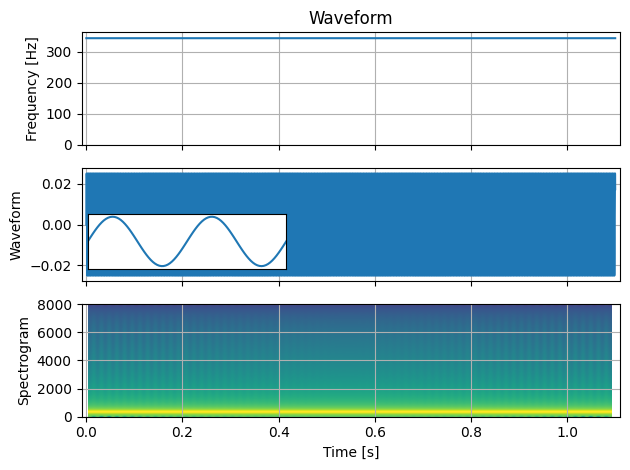

In [32]:
target_amplitude = 0.025

sin_osc = text2synth.SinOscillator(SAMPLE_RATE)
plot(F0_FULL[0], target_amplitude * sin_osc(F0_FULL)[0], SAMPLE_RATE, zoom=True)

Epoch 0000 | Loss: 0.001406 | Amp: 0.090000
Epoch 0050 | Loss: 0.000004 | Amp: 0.021561
Epoch 0099 | Loss: 0.000000 | Amp: 0.024654


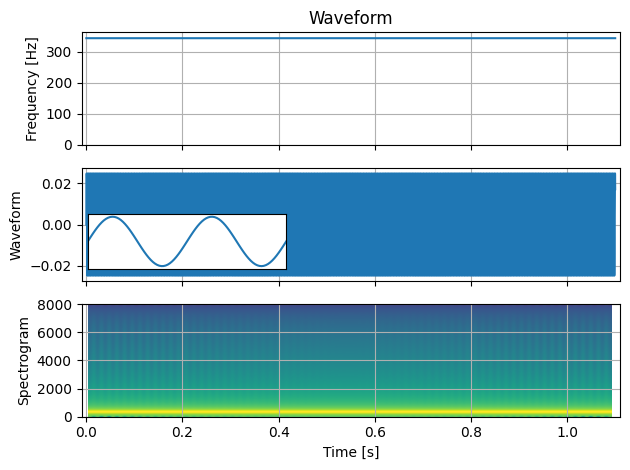

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import auraloss

# Training Constants
EPOCHS = 100
LEARNING_RATE = 0.01

# Your oscillator
sin_osc = text2synth.SinOscillator(SAMPLE_RATE)
target_audio = target_amplitude * sin_osc(F0_FULL).detach()

# Learnable amplitude
class AmplitudeLearner(nn.Module):
    def __init__(self):
        super().__init__()
        self.amplitude = nn.Parameter(torch.tensor(0.1))  # Initial guess

    def forward(self, f0):
        osc = sin_osc(f0)
        return self.amplitude * osc

model = AmplitudeLearner()

# Loss function from auraloss
loss_fn = auraloss.time.LogCoshLoss()  # or L1Loss(), MRSTFTLoss(), etc.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    output = model(F0_FULL)
    loss = loss_fn(output, target_audio)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch {epoch:04d} | Loss: {loss.item():.6f} | Amp: {model.amplitude.item():.6f}")

# Plot final waveform
with torch.no_grad():
    predicted_audio = model(F0_FULL)
plot(F0_FULL[0], predicted_audio[0], SAMPLE_RATE, zoom=True)